<a href="https://colab.research.google.com/github/tsengcc2023/Financial-Big-Data-Analysis/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

延用上週爬取的股價資料，完成本次作業要求：
1. 計算技術指標（SMA、RSI、MACD）
2. 可視化 K 線圖
3. 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

# 爬取股價資料

In [1]:
pip install yfinance

In [2]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f1f30334959e0054693a19eb0965998dad7b9937a4e7f26984bc9d0569f3c733
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
# 匯入所需的函式庫
import yfinance as yf
import pandas as pd

# 爬取台積電（2330.TW）股價資料的函數
def fetch_stock_data(stock_id, start_date, end_date):
    df = yf.download(stock_id, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    return df

# 爬取資料
stock_id = '2330.TW'
start_date = '2024-01-01'
end_date = '2024-09-29'
stock_data = fetch_stock_data(stock_id, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-02,590.0,593.0,589.0,593.0,585.360962,26059058
1,2024-01-03,584.0,585.0,576.0,578.0,570.554199,37106763
2,2024-01-04,580.0,581.0,577.0,580.0,572.528381,15309129
3,2024-01-05,578.0,580.0,574.0,576.0,568.579956,18158971
4,2024-01-08,582.0,585.0,579.0,583.0,575.489746,17761275
...,...,...,...,...,...,...,...
174,2024-09-23,971.0,977.0,971.0,977.0,977.000000,14497067
175,2024-09-24,976.0,987.0,971.0,987.0,987.000000,26785975
176,2024-09-25,1000.0,1005.0,998.0,1005.0,1005.000000,39405222
177,2024-09-26,1010.0,1015.0,1005.0,1015.0,1015.000000,38321585


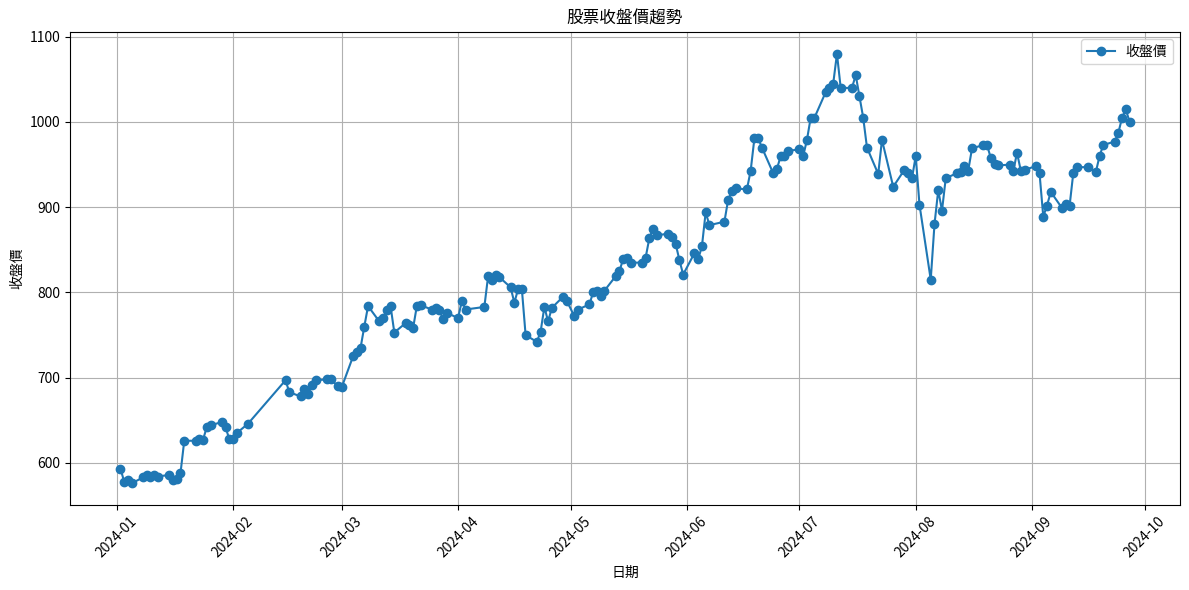

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager
import wget

# 下載中文字體
wget.download("https://github.com/GrandmaCan/ML/raw/main/Resgression/ChineseFont.ttf")

# 將下載的中文字體引入到 matplotlib 的字體管理
fontManager.addfont("ChineseFont.ttf")
mpl.rc('font', family="ChineseFont")  # 設定 matplotlib 使用此字體

def visualize_stock_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], marker='o', label='收盤價')
    plt.title('股票收盤價趨勢')
    plt.xlabel('日期')
    plt.ylabel('收盤價')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 呼叫函數可視化股價趨勢
visualize_stock_data(stock_data)

# 1️⃣ 計算技術指標（SMA、RSI、MACD）

In [7]:
# 計算技術指標的函數
def calculate_technical_indicators(df):
    # 計算20日簡單移動平均線 (SMA)
    df['20_SMA'] = df['Close'].rolling(window=20).mean()

    # 計算相對強弱指數 (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 計算指數移動平均線 (EMA)
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

    # 計算 MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df

# 計算技術指標
stock_data = calculate_technical_indicators(stock_data)

# 2️⃣ 可視化 K 線圖

In [8]:
import plotly.graph_objects as go

# 可視化 K 線圖的函數
def visualize_candlestick(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                                          open=df['Open'],
                                          high=df['High'],
                                          low=df['Low'],
                                          close=df['Close'])])
    fig.update_layout(title='K 線圖', xaxis_title='日期', yaxis_title='價格')
    fig.show()

# 可視化 K 線圖
visualize_candlestick(stock_data)

# 3️⃣ 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

Linear Regression 訓練完成
Decision Tree 訓練完成
Random Forest 訓練完成


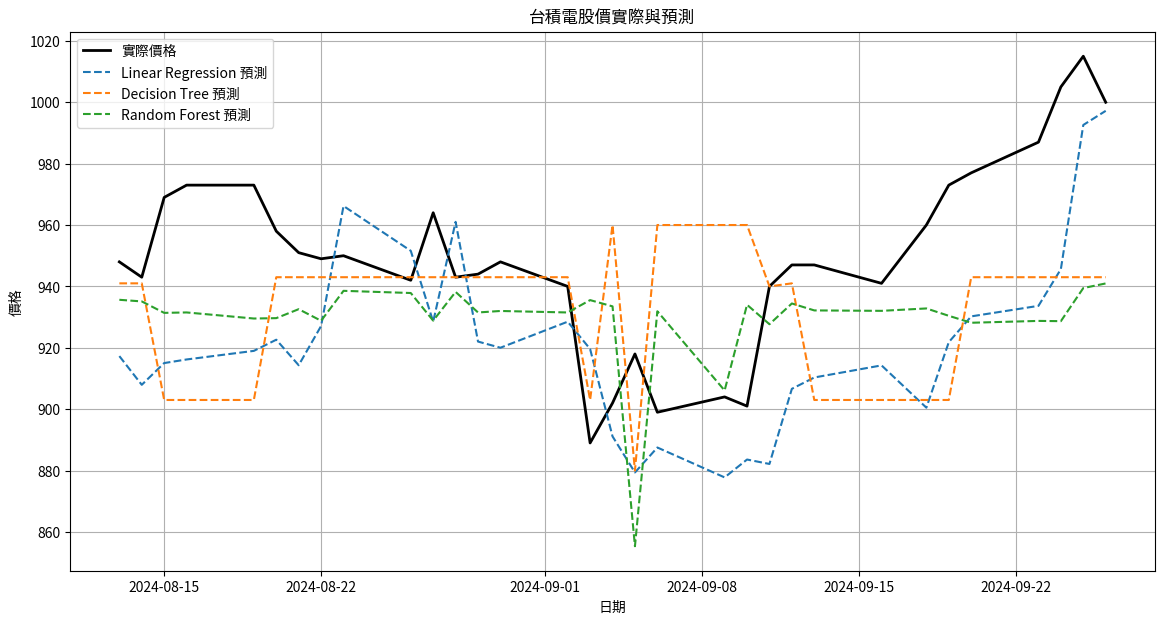

In [9]:
# 引入所需的機器學習函式庫
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 預測未來1天價格的函數
def prepare_data_for_prediction(df):
    df['Future_Price'] = df['Close'].shift(-1)  # 預測未來1天的價格
    df.dropna(inplace=True)  # 去除缺失值
    X = df[['20_SMA', 'RSI', 'MACD']]  # 特徵
    y = df['Future_Price']  # 標籤
    return train_test_split(X, y, test_size=0.2, shuffle=False)

# 拆分資料集
X_train, X_test, y_train, y_test = prepare_data_for_prediction(stock_data)

# 訓練模型的函數
def train_models(X_train, y_train):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        print(f"{name} 訓練完成")
    return models

# 訓練模型
models = train_models(X_train, y_train)

# 預測的函數
def predict_prices(models, X_test):
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_test)
    return predictions

# 預測
predictions = predict_prices(models, X_test)

# 可視化預測的函數
def visualize_predictions(df, y_test, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'][-len(y_test):], y_test, label='實際價格', color='black', linewidth=2)

    for name, pred in predictions.items():
        plt.plot(df['Date'][-len(y_test):], pred, label=f'{name} 預測', linestyle='--')

    plt.xlabel('日期')
    plt.ylabel('價格')
    plt.title('台積電股價實際與預測')
    plt.legend()
    plt.grid(True)
    plt.show()

# 可視化預測
visualize_predictions(stock_data, y_test, predictions)